In [1]:
%pylab inline
import sys
sys.path.append('../src/')
from utils import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.model_selection import KFold

In [4]:
cls = ElasticNet(alpha=.00062, l1_ratio=.825)

In [5]:
train, test = get_data()

In [6]:
cross_val(cls, train, 8)

0.13135942084222405

In [7]:
kf = KFold(n_splits=8)
preds = []
for trainix, testix in kf.split(train):
    trn, tst = train.iloc[trainix], train.iloc[testix]
    cls.fit(trn.drop(['Id', 'SalePrice'], axis=1), trn.SalePrice)
    pred = cls.predict(tst.drop(['Id', 'SalePrice'], axis=1))
    preds.append(pd.DataFrame({'Id': tst.Id, 'Predicted': pred, 'SalePrice': tst.SalePrice}))

In [8]:
pred = pd.concat(preds, axis=0)
pred.sort_values(by='Id', inplace=True)
pred['Err'] = pred.Predicted - pred.SalePrice

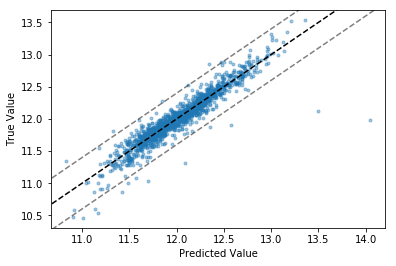

In [13]:
width = 0.4
plot(pred.Predicted, pred.SalePrice, '.', alpha=0.4)
xl = xlim(); yl = ylim()
plot([0,100], [0,100], '--k')
plot([-width,100-width], [0,100], '--k', alpha=.5)
plot([width,100+width], [0,100], '--k', alpha=.5)
xlim(xl); ylim(yl)
xlabel('Predicted Value')
ylabel('True Value')

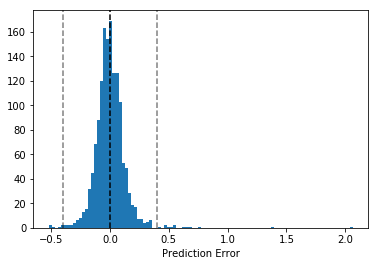

In [15]:
x = pred.Err.values
hist(x, 100);
axvline(x.mean(), linestyle='--', color='k')
axvline(x.mean() + width, linestyle='--', color='k', alpha=.5)
axvline(x.mean() - width, linestyle='--', color='k', alpha=.5)
xlabel('Prediction Error')

In [16]:
badIds = pred[abs(pred.Err) > width].Id.values
badIds

array([  31,   89,  329,  411,  463,  496,  524,  589,  633,  711,  826,
        917,  969,  971, 1182, 1299, 1325, 1424, 1433])

In [17]:
pred[abs(pred.Err) > .5]

,Id,Predicted,SalePrice,Err
30,31,11.133836,10.596635,0.537201
88,89,10.827347,11.350407,-0.523060
462,463,11.701482,11.041048,0.660433
495,496,11.006699,10.460242,0.546457
523,524,13.495724,12.126759,1.368966
632,633,12.084682,11.320554,0.764129
710,711,11.417409,10.858999,0.558410
825,826,12.341147,12.860999,-0.519852
968,969,11.172021,10.542706,0.629314
1298,1299,14.048458,11.982929,2.065529


### Let's try again without the outliers

In [18]:
train1 = train[~train.Id.isin(badIds)]
train.shape, train1.shape

((1460, 305), (1441, 305))

In [19]:
kf = KFold(n_splits=8)
preds = []
for trainix, testix in kf.split(train1):
    trn, tst = train1.iloc[trainix], train1.iloc[testix]
    cls.fit(trn.drop(['Id', 'SalePrice'], axis=1), trn.SalePrice)
    pred = cls.predict(tst.drop(['Id', 'SalePrice'], axis=1))
    preds.append(pd.DataFrame({'Id': tst.Id, 'Predicted': pred, 'SalePrice': tst.SalePrice}))

In [20]:
pred = pd.concat(preds, axis=0)
pred.sort_values(by='Id', inplace=True)
pred['Err'] = pred.Predicted - pred.SalePrice

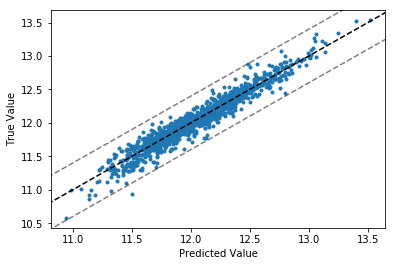

In [21]:
plot(pred.Predicted, pred.SalePrice, '.')
xl = xlim(); yl = ylim()
plot([0,100], [0,100], '--k')
plot([-width,100-width], [0,100], '--k', alpha=.5)
plot([width,100+width], [0,100], '--k', alpha=.5)
xlim(xl); ylim(yl)
xlabel('Predicted Value')
ylabel('True Value')

In [22]:
pred.Err.std()

0.09812577126119379

### Build a submission without training on the outliers

In [23]:
clss = [ElasticNet(alpha=.00062, l1_ratio=.825), RandomForestRegressor(200),
        GradientBoostingRegressor(learning_rate=.1, n_estimators=200), SVR(C=9, gamma=.0025)]

In [24]:
cls = StackingRegressor(regressors=clss, meta_regressor=AvgReg())

In [26]:
build_submission(cls, train1, test, '../data/submission10.csv')

array([ 11.71300722,  11.93157704,  12.11375916, ...,  11.95567841,
        11.65518419,  12.32429087])